<div class="alert alert-block alert-info">
__Name__: pangenome_proximity<br/>
__Description__: Examine random forest proximity between falsely and correctly classifed genomes<br/>
__Author__: Matthew Whiteside matthew dot whiteside at canada dot ca<br/>
__Date__: Oct 24, 2017<br/>
__TODO__:<br/>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14.0,14.0]

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('../pangenome')
import config
import utils
import classify
pg, genome_list, locus_list = utils.read_panseq(config.PANSEQ['pangenome_file'])
amr,amr_list = utils.read_amr(config.PHENOTYPE['amr_file'], genome_list)
annot = utils.read_annot(config.ANNOTATION['blast_file'])

In [5]:
# Split into train & test for ampicillin
d = np.argwhere(amr_list == 'ampicillin').item(0)
validrows = ~np.isnan(amr[:,d])
validrows
X = pg[validrows,:]
y = amr[validrows,d]

test_size = int( 0.2 * len( y ) )
np.random.seed( 2123 )
indices = np.random.permutation(X.shape[0])
X_train = X[ indices[:-test_size] ]
y_train = y[ indices[:-test_size] ]
X_test = X[ indices[-test_size:] ]
y_test = y[ indices[-test_size:] ]

In [107]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier

In [6]:
# Build classifier & fit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=4, max_features=0.85,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=4,
            oob_score=False, random_state=0, verbose=False,
            warm_start=False)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.69      0.75      0.72        12
        1.0       0.95      0.93      0.94        56

avg / total       0.90      0.90      0.90        68



In [8]:
# Identify neighbours of false predictions
fni = indices[-test_size:][(y_pred != y_test) & (y_test == 1)]
fpi = indices[-test_size:][(y_pred != y_test) & (y_test == 0)]

In [9]:
fpi

array([  4, 125, 120])

In [10]:
fni

array([ 91, 250,   0, 190])

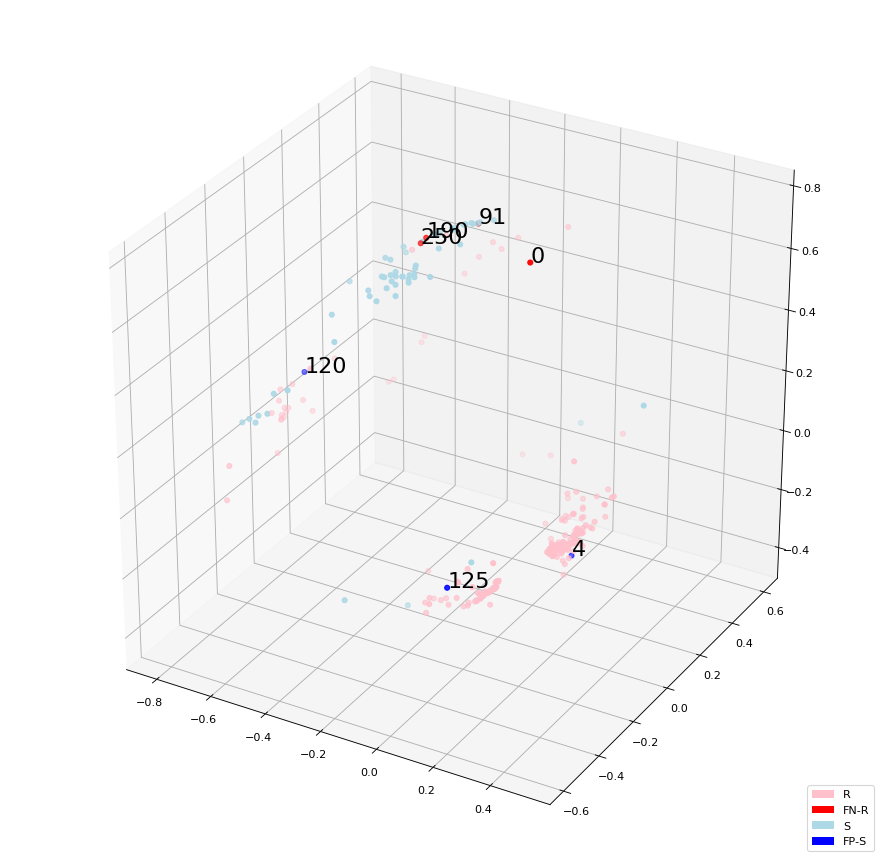

In [32]:
# Display MMDS projection of distances
D = classify.proximity_matrix(rf, X)
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
mds =  manifold.MDS(n_components=3, random_state=4, dissimilarity='precomputed', n_jobs=4)
D_mds = mds.fit_transform(D)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
N = D_mds.shape[0]

# Plot
fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
colours = np.array(['lightblue'] * N)
colours[y == 1] = 'pink'
colours[fni] = 'red'
colours[fpi] = 'blue'
ax.scatter(D_mds[:, 0], D_mds[:, 1], D_mds[:,2], c=colours)
#ac.axis('equal');

# Legend
classes = ['R','FN-R','S', 'FP-S']
class_colours = ['pink', 'red','lightblue', 'blue']
dots = []
for i in range(0,len(class_colours)):
    dots.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(dots,classes,loc=4)

# Labels
for i in np.concatenate((fpi,fni)):
     ax.text(D_mds[i,0],D_mds[i,1],D_mds[i,2], '%s' % (str(i)), size=20, zorder=1, color='k')
    
plt.show()

In [13]:
np.argsort(D[fpi,:])[:,:5]

array([[  4, 143, 182, 300, 276],
       [125, 218,  51, 317,  94],
       [120, 292, 338, 172, 214]])

In [14]:
np.sort(D[fpi,:])[:,:5]

array([[ 0.     ,  0.03875,  0.05   ,  0.05   ,  0.05   ],
       [ 0.     ,  0.04   ,  0.065  ,  0.1325 ,  0.1325 ],
       [ 0.     ,  0.14625,  0.15   ,  0.17375,  0.17625]])

In [15]:
def prox_summary(i,j,rf):
    print("Phenotype i: {}".format(y[i]))
    print("Phenotype j: {}".format(y[j]))
    ind = (X[i].toarray() != X[j].toarray())[0]
    print("Differences: {}".format(sum(ind)))
#     print("Importances: {}".format(np.sort(rf.feature_importances_[ind])))
#     l = locus_list[ind]
#     a = annot[np.in1d(annot.LocusID,l)]
#     print(np.sort(np.unique(a.Description)))


In [16]:
prox_summary(4,143,rf)

Phenotype i: 0.0
Phenotype j: 1.0
Differences: 49


In [17]:
# Contributing features to false prediction and neighbour
from treeinterpreter import treeinterpreter as ti

In [18]:
genomefpi = 4
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.00522483  0.99477517]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: -0.0378, 0.0378 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: -0.0369, 0.0369 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: -0.0362, 0.0362 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: -0.0362, 0.0362 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
28625988430000: -0.0172, 0.0172 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
21092833621000: 0.0048, -0.0048 ...gi|486298149|ref|WP_001575065.1| hypothetical protein [Salmonella enterica]
27119357187000: -0.0032, 0.0032 ...gi|518681082|ref|WP_019842775.1| hypothetical protein [Escherichia coli]
12053047863000: -0.003, 0.003 ...gi|490348163|ref|WP_004227936.1| hypothetical protein [Klebsiella pneumoniae]
3013261927100

In [19]:
# Neighbour prediction
genomefpi = 143
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.00624971  0.99375029]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: -0.0378, 0.0378 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: -0.0369, 0.0369 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: -0.0362, 0.0362 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: -0.0362, 0.0362 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
28625988430000: -0.0172, 0.0172 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
21092833621000: 0.0043, -0.0043 ...gi|486298149|ref|WP_001575065.1| hypothetical protein [Salmonella enterica]
27119357187000: -0.0033, 0.0033 ...gi|518681082|ref|WP_019842775.1| hypothetical protein [Escherichia coli]
30132619271000: -0.003, 0.003 ...gi|446237724|ref|WP_000315579.1| hypothetical protein, partial [Salmonella ent
120530478630

In [66]:
prox_summary(125,218,rf)

Phenotype i: 0.0
Phenotype j: 1.0
Differences: 162


In [21]:
genomefpi = 125
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.04446156  0.95553844]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: -0.0378, 0.0378 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: -0.0369, 0.0369 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: -0.0362, 0.0362 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: -0.0362, 0.0362 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
28625988430000: -0.0172, 0.0172 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
25612726485000: 0.0163, -0.0163 ...gi|487532247|ref|WP_001711331.1| putative inner membrane protein, partial [Sal
12053047863000: 0.012, -0.012 ...gi|490348163|ref|WP_004227936.1| hypothetical protein [Klebsiella pneumoniae]
30132619271000: 0.0103, -0.0103 ...gi|446237724|ref|WP_000315579.1| hypothetical protein, partial [Salmonella ent
2109

In [67]:
genomefpi = 218
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.04507804  0.95492196]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: -0.0378, 0.0378 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: -0.0369, 0.0369 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: -0.0362, 0.0362 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: -0.0362, 0.0362 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
28625988430000: -0.0172, 0.0172 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
25612726485000: 0.0165, -0.0165 ...gi|487532247|ref|WP_001711331.1| putative inner membrane protein, partial [Sal
12053047863000: 0.0117, -0.0117 ...gi|490348163|ref|WP_004227936.1| hypothetical protein [Klebsiella pneumoniae]
30132619271000: 0.0095, -0.0095 ...gi|446237724|ref|WP_000315579.1| hypothetical protein, partial [Salmonella ent
21

In [23]:
rf.feature_importances_[locus_list == '25612726264000']

array([ 0.02370558])

In [24]:
present = (X[:,locus_list == '25612726264000'].toarray() == 1)

In [25]:
y[present[:,0]]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.])

In [33]:
# False Negatives
np.argsort(D[fni,:])[:,:5]

array([[ 91, 282, 280, 261, 238],
       [250, 158,  43,  33, 142],
       [  0, 334,  80, 257, 121],
       [190,  33,  43, 124, 335]])

In [34]:
np.sort(D[fni,:])[:,:5]

array([[ 0.     ,  0.105  ,  0.1175 ,  0.15875,  0.2375 ],
       [ 0.     ,  0.21625,  0.2425 ,  0.2475 ,  0.2975 ],
       [ 0.     ,  0.4325 ,  0.46375,  0.4675 ,  0.47375],
       [ 0.     ,  0.14875,  0.1575 ,  0.2075 ,  0.21125]])

In [35]:
prox_summary(250,158,rf)

Phenotype i: 1.0
Phenotype j: 0.0
Differences: 112


In [36]:
prox_summary(190,33,rf)

Phenotype i: 1.0
Phenotype j: 0.0
Differences: 71


In [37]:
prox_summary(91,282,rf)

Phenotype i: 1.0
Phenotype j: 0.0
Differences: 63


In [38]:
genomefpi = 250
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.77617852  0.22382148]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: 0.1109, -0.1109 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: 0.1085, -0.1085 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: 0.1066, -0.1066 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: 0.1048, -0.1048 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
19586202470000: 0.0818, -0.0818 ...gi|485701964|ref|WP_001335071.1| hypothetical protein, partial [Escherichia co
28625988430000: 0.0512, -0.0512 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
28625988412000: -0.0414, 0.0414 ...gi|486190462|ref|WP_001543366.1| hypothetical protein, partial [Escherichia co
22599464615000: -0.0327, 0.0327 ...gi|187736860|ref|YP_001816598.1| dihydropteroate synthase [Escherichia coli 15
1

In [40]:
X[250,locus_list == '16572940561000'].toarray(); 

array([[0]], dtype=int8)

In [42]:
X[250,locus_list == '22599464615000'].toarray()

array([[1]], dtype=int8)

In [43]:
genomefpi = 190
genomefp_features = X[genomefpi]
predictionfp, biasfp, contributionsfp = ti.predict(rf, genomefp_features)
print("Prediction", predictionfp)
print("Bias (trainset prior)", biasfp)
print("Feature contributions:")
contributing_features_fp = (np.absolute(contributionsfp[0])[:,1].argsort()[::-1])[:10]
m = np.column_stack((locus_list[contributing_features_fp],
contributionsfp[0][contributing_features_fp,:]))
for i in np.arange(m.shape[0]):
    r = m[i,:]
    a = annot.LocusID == r[0]
    print("{}: {}, {} ...{} {}".format(r[0],np.round(r[1],4),np.round(r[2],4),annot.loc[a,'Accession'].values[0], annot.loc[a, 'Description'].values[0][0:45]))

Prediction [[ 0.7815799  0.2184201]]
Bias (trainset prior) [[ 0.18925639  0.81074361]]
Feature contributions:
16572940561000: 0.1109, -0.1109 ...gi|90265358|emb|CAJ77040.1| Transposase [Acinetobacter baumannii]
19586202464000: 0.1085, -0.1085 ...gi|487908194|ref|WP_001981660.1| MFS transporter [Vibrio cholerae]
18079571516000: 0.1066, -0.1066 ...gi|553902307|ref|WP_023139374.1| LysR family transcriptional regulator [Salmon
21092833417000: 0.1048, -0.1048 ...gi|169797577|ref|YP_001715370.1| tetracycline repressor protein class G [Acine
19586202470000: 0.0812, -0.0812 ...gi|485701964|ref|WP_001335071.1| hypothetical protein, partial [Escherichia co
28625988430000: 0.0512, -0.0512 ...gi|550903217|ref|YP_008672309.1| chloramphenicol and florfenicol resistance pr
22599464615000: -0.0322, 0.0322 ...gi|187736860|ref|YP_001816598.1| dihydropteroate synthase [Escherichia coli 15
13559678635000: 0.0244, -0.0244 ...gi|18466603|ref|NP_569411.1| beta-lactamase [Salmonella enterica subsp. en
2561272

In [44]:
X[250,locus_list == '22599464615000'].toarray()

array([[1]], dtype=int8)

In [64]:
y[(X[:,locus_list == '16572940561000'].toarray() == 1)[:,0]]

array([ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [65]:
y[(X[:,locus_list == '16572940561000'].toarray() == 0)[:,0]]

array([ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,
        0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.])

In [91]:
gb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005308968883120171, loss='deviance',
              max_depth=None, max_features=0.1,
              max_leaf_nodes=None, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=1, subsample=1.0, verbose=0,
              warm_start=False)

In [92]:
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test.toarray())
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.69      0.75      0.72        12
        1.0       0.95      0.93      0.94        56

avg / total       0.90      0.90      0.90        68



In [93]:
# Identify neighbours of false predictions
fni = indices[-test_size:][(y_pred != y_test) & (y_test == 1)]
fpi = indices[-test_size:][(y_pred != y_test) & (y_test == 0)]

In [94]:
fni

array([ 91, 250,   0, 190])

In [95]:
fpi

array([  4, 125, 120])

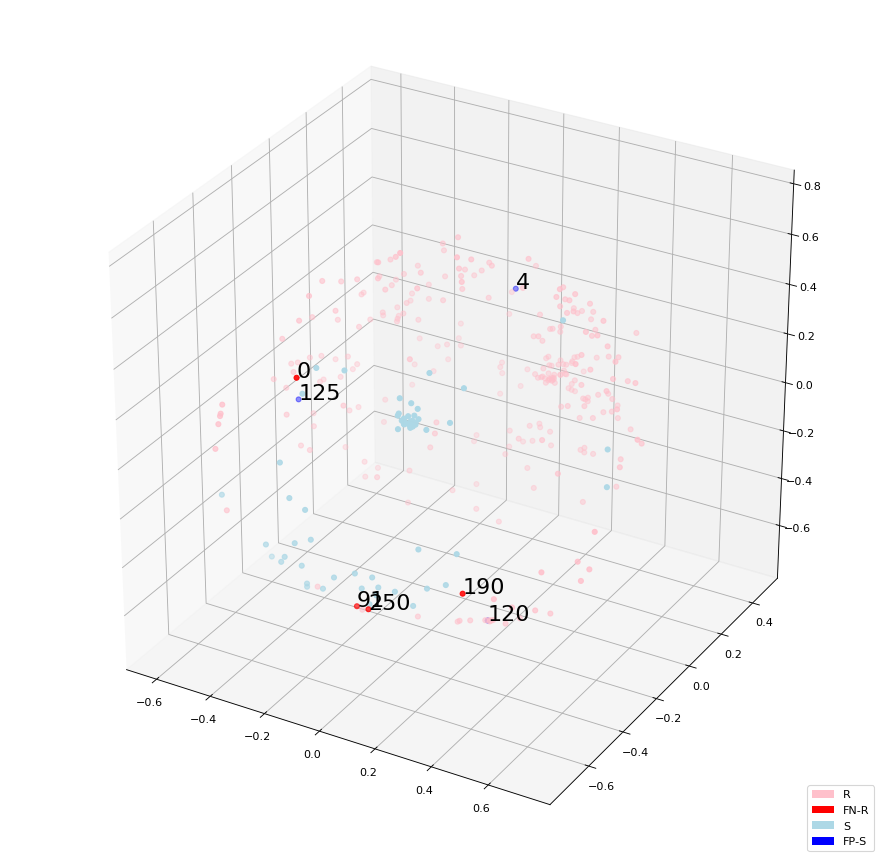

In [105]:
D = classify.proximity_matrix(gb, X)
D = D[:,:,0]
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
mds =  manifold.MDS(n_components=3, random_state=4, dissimilarity='precomputed', n_jobs=4)
D_mds = mds.fit_transform(D)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
N = D_mds.shape[0]

# Plot
fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
colours = np.array(['lightblue'] * N)
colours[y == 1] = 'pink'
colours[fni] = 'red'
colours[fpi] = 'blue'
ax.scatter(D_mds[:, 0], D_mds[:, 1], D_mds[:,2], c=colours)
#ac.axis('equal');

# Legend
classes = ['R','FN-R','S', 'FP-S']
class_colours = ['pink', 'red','lightblue', 'blue']
dots = []
for i in range(0,len(class_colours)):
    dots.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(dots,classes,loc=4)

# Labels
for i in np.concatenate((fpi,fni)):
     ax.text(D_mds[i,0],D_mds[i,1],D_mds[i,2], '%s' % (str(i)), size=20, zorder=1, color='k')
    
plt.show()

In [111]:
et = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=0.4105662978479582,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=2982, n_jobs=8,
           oob_score=False, random_state=2, verbose=False,
           warm_start=False)

In [112]:
et.fit(X_train, y_train)
y_pred = et.predict(X_test.toarray())
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.53      0.75      0.62        12
        1.0       0.94      0.86      0.90        56

avg / total       0.87      0.84      0.85        68



In [113]:
# Identify neighbours of false predictions
fni = indices[-test_size:][(y_pred != y_test) & (y_test == 1)]
fpi = indices[-test_size:][(y_pred != y_test) & (y_test == 0)]

In [114]:
fni

array([101,  62,  91, 250,   0, 190, 268, 234])

In [115]:
fpi

array([  4, 125, 120])

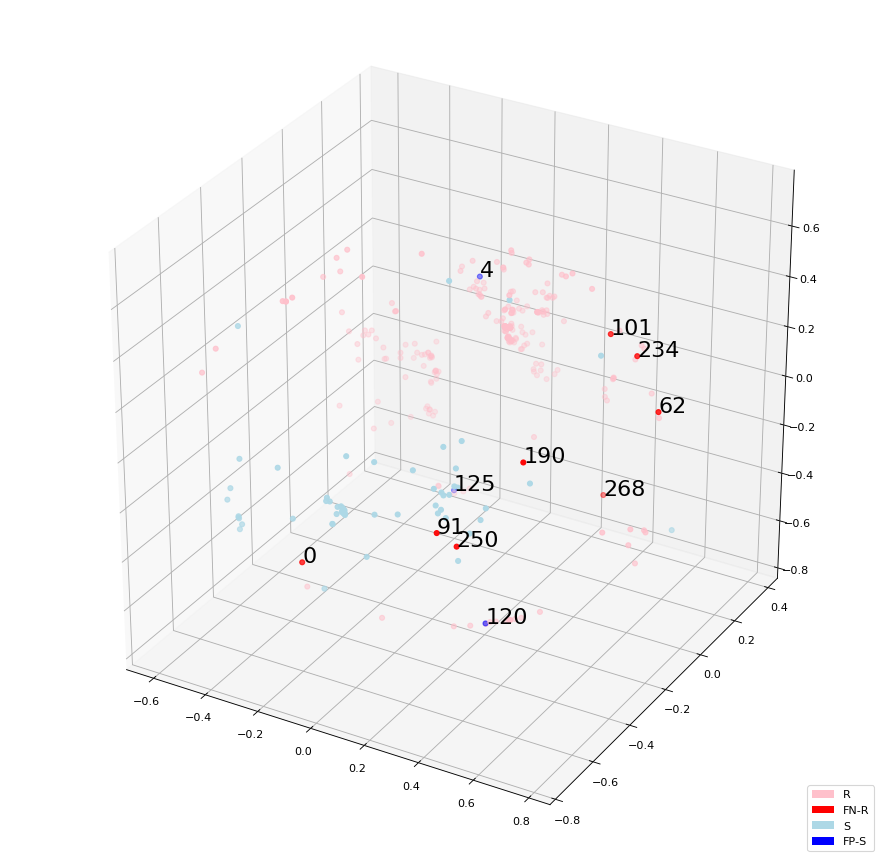

In [117]:
D = classify.proximity_matrix(et, X)
#D = D[:,:,0]
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
mds =  manifold.MDS(n_components=3, random_state=4, dissimilarity='precomputed', n_jobs=4)
D_mds = mds.fit_transform(D)
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
N = D_mds.shape[0]

# Plot
fig = plt.figure(figsize=(14, 14), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection='3d')
colours = np.array(['lightblue'] * N)
colours[y == 1] = 'pink'
colours[fni] = 'red'
colours[fpi] = 'blue'
ax.scatter(D_mds[:, 0], D_mds[:, 1], D_mds[:,2], c=colours)
#ac.axis('equal');

# Legend
classes = ['R','FN-R','S', 'FP-S']
class_colours = ['pink', 'red','lightblue', 'blue']
dots = []
for i in range(0,len(class_colours)):
    dots.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(dots,classes,loc=4)

# Labels
for i in np.concatenate((fpi,fni)):
     ax.text(D_mds[i,0],D_mds[i,1],D_mds[i,2], '%s' % (str(i)), size=20, zorder=1, color='k')
    
plt.show()